In [1]:
import heapq

import mglearn as mglearn
import np as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import sklearn_evaluation
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.svm import SVC

!pip install numpy scipy scikit-learn matplotlib pandas
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.decomposition import PCA

import heapq

You should consider upgrading via the '/Users/engineer/workspace/cse590-machine-learning/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
X_train = pd.read_csv("./dataset/X_train.csv").values
y_train = pd.read_csv("./dataset/y_train.csv").values.ravel()
X_test = pd.read_csv("./dataset/X_test.csv").values
y_test = pd.read_csv("./dataset/y_test.csv").values.ravel()

scaler_standard = StandardScaler().fit(X_train)
X_train_standard = scaler_standard.transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

scaler_robust = RobustScaler().fit(X_train)
X_train_robust = scaler_robust.transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

scaler_minmax = MinMaxScaler().fit(X_train)
X_train_minmax = scaler_minmax.transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=256)
mlp.fit(X_train_standard, y_train)
mlp_predictions = mlp.predict_proba(X_test_standard)
print(len(mlp_predictions))


4999


In [23]:
svm = SVC(kernel='poly', C=10, degree=3, probability=True)
svm.fit(X_train_minmax, y_train)
svm_predictions = svm.predict_proba(X_test_minmax)
print(len(svm_predictions))


4999


In [24]:
pred_proba_class_svm = svm_predictions[:, 0]
pred_prob_class_2_svm = svm_predictions[:, 1]
pred_prob_class_3_svm = svm_predictions[:, 2]
pred_prob_class_4_svm = svm_predictions[:, 3]
pred_prob_class_5_svm = svm_predictions[:, 4]

pred_proba_class_mlp = mlp_predictions[:, 0]
pred_prob_class_2_mlp = mlp_predictions[:, 1]
pred_prob_class_3_mlp = mlp_predictions[:, 2]
pred_prob_class_4_mlp = mlp_predictions[:, 3]
pred_prob_class_5_mlp = mlp_predictions[:, 4]

In [82]:
print(mlp_predictions[0])
print(mlp_predictions[1])
print(mlp_predictions[4998])

print(type(mlp_predictions))

[9.99898618e-01 7.53150988e-05 1.27823787e-06 2.47859314e-05
 2.88439511e-09]
[1.00000000e+00 1.52682653e-13 3.69123696e-11 1.44272817e-10
 2.48829521e-13]
[4.12566979e-12 8.46277786e-09 1.02614001e-01 1.55710178e-09
 8.97385989e-01]
<class 'numpy.ndarray'>


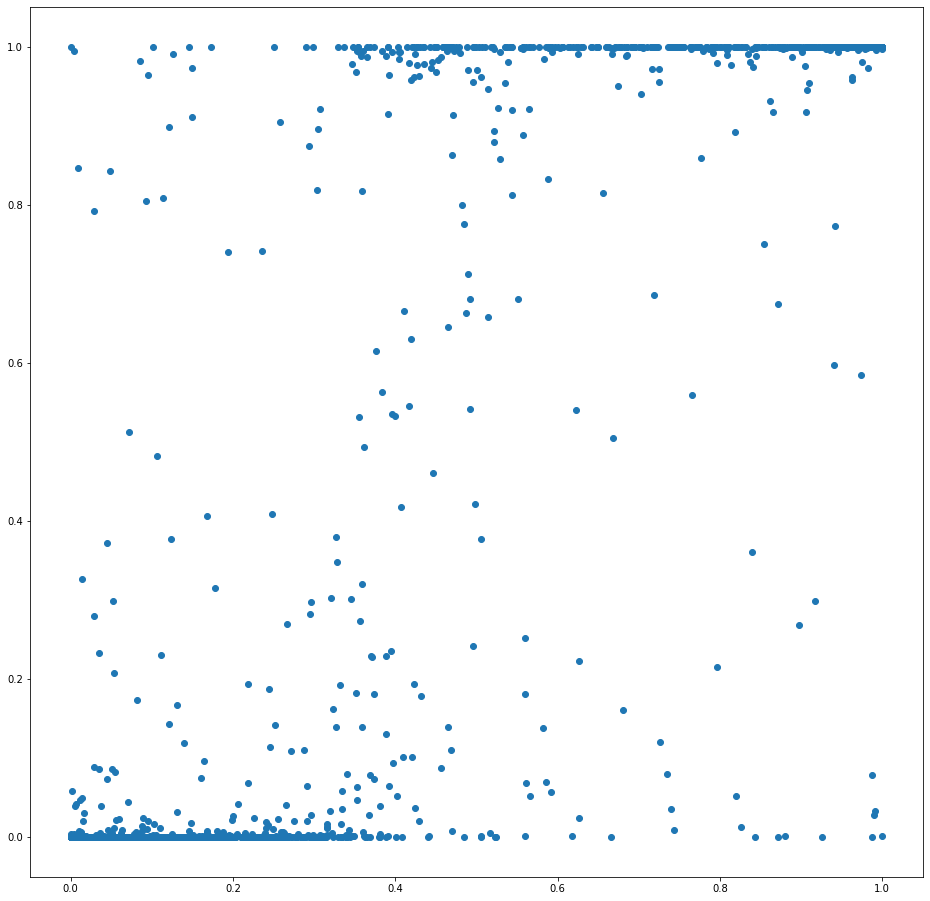

In [102]:
fig, ax = plt.subplots()
fig.set_figheight(16)
fig.set_figwidth(16)
plt.scatter(pred_proba_class_svm, pred_proba_class_mlp)

In [31]:
# get the class probabilities
# where those probabilities over 50% correctly classified? like what if the 90% predictions where incorrect
# run a test to see how many that is before you try to graph it
corrects = 0
guesses = 0
for i in range(4999):
    x = pred_proba_class_svm[i]
    y = y_test[i]
    if x > 0.50:
        guesses += 1
        if y == 0:
            corrects += 1

print(corrects)
print(guesses)
print(corrects / guesses)

844
893
0.9451287793952967


In [33]:
class_1_good_svm_bad_mlp = []
for i in range(4999):
    if pred_proba_class_svm[i] >= 0.8 and pred_proba_class_mlp[i] <= 0.2:
        class_1_good_svm_bad_mlp.append(i)

print(len(class_1_good_svm_bad_mlp))

11


In [35]:
class_1_good_mlp_bad_svm = []
for i in range(4999):
    if pred_proba_class_mlp[i] >= 0.8 and pred_proba_class_svm[i] <= 0.2:
        class_1_good_mlp_bad_svm.append(i)

print(len(class_1_good_mlp_bad_svm))

15


In [107]:
def extract_easy_vs_hard(good_list, bad_list, x, y):
    desired_bucket = []
    for i in reversed(range(len(good_list))):
        if good_list[i] >= 0.8 and bad_list[i] <= 0.2:
            desired_bucket.append([x[i], y[i]])
            good_list.pop(i)
            bad_list.pop(i)

    return np.array(desired_bucket), good_list, bad_list


def separate_and_graph_prediction_comparison(
        title_class,
        pred_proba_class_svm,
        pred_proba_class_mlp
):
    copy_class_pred_svm = list(pred_proba_class_svm)
    copy_class_pred_mlp = list(pred_proba_class_mlp)
    
    class_0_easy_svm_x_y, copy_class_pred_svm, copy_class_pred_mlp = extract_easy_vs_hard(
        copy_class_pred_svm,
        copy_class_pred_mlp,
        copy_class_pred_svm,
        copy_class_pred_mlp,
    )
    
    class_0_easy_mlp_x_y, copy_class_pred_mlp, copy_class_pred_svm = extract_easy_vs_hard(
        copy_class_pred_mlp,
        copy_class_pred_svm,
        copy_class_pred_svm,
        copy_class_pred_mlp,
    )
    
    plot_easy_hard(
        'Class 0: T-Shirt/Top',
        easy_svm_xy=class_0_easy_svm_x_y,
        easy_mlp_xy=class_0_easy_mlp_x_y,
        remaining_svm=copy_class_pred_svm,
        remaining_mlp=copy_class_pred_mlp
    )

def plot_easy_hard(title_class, easy_svm_xy, easy_mlp_xy, remaining_svm, remaining_mlp):
    global fig, ax
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.title(f'Prediction Comparisons for {title_class}')
    plt.xlabel('SVM Predictions')
    plt.ylabel('MLP Predictions')
    plt.scatter(easy_svm_xy[:, 0], easy_svm_xy[:, 1], c='g', label='East SVM/Hard MLP')
    plt.scatter(easy_mlp_xy[:, 0], easy_mlp_xy[:, 1], c='c', label='East MLP/Hard SVM')
    plt.scatter(remaining_svm, remaining_mlp, c='m')
    plt.legend()

# 0: T-shirt/top
# 1: Trouser
# 2: Pullover
# 3: Dress
# 4: Coat

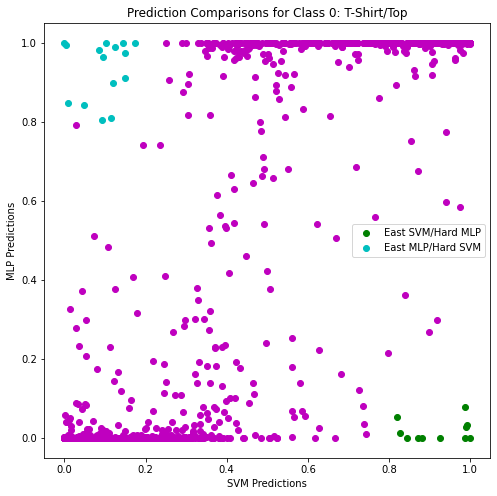

In [109]:
copy_class_0_pred_svm = list(pred_proba_class_svm)
copy_class_0_pred_mlp = list(pred_proba_class_mlp)

class_0_easy_svm_x_y, copy_class_0_pred_svm, copy_class_0_pred_mlp = extract_easy_vs_hard(
    copy_class_0_pred_svm,
    copy_class_0_pred_mlp,
    copy_class_0_pred_svm,
    copy_class_0_pred_mlp,
)

class_0_easy_mlp_x_y, copy_class_0_pred_mlp, copy_class_0_pred_svm = extract_easy_vs_hard(
    copy_class_0_pred_mlp,
    copy_class_0_pred_svm,
    copy_class_0_pred_svm,
    copy_class_0_pred_mlp,
)

plot_easy_hard(
    'Class 0: T-Shirt/Top',
    easy_svm_xy=class_0_easy_svm_x_y,
    easy_mlp_xy=class_0_easy_mlp_x_y,
    remaining_svm=copy_class_0_pred_svm,
    remaining_mlp=copy_class_0_pred_mlp
)
